# Import the libraries:

In [2]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import sklearn.metrics as ms
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import keras
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.impute import SimpleImputer
from pandas.tseries.offsets import DateOffset
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Read files:

In [3]:
carbon = pd.read_csv("jordan_co2_emissions.csv")
sector = pd.read_csv("Sectors.csv",usecols=['Year','Waste','Transport','Electricity and heat','Industry'])
mergedata = pd.merge(carbon, sector, on="Year")

# Files Explaination:

In the study we have four files, each file contains number of columns that  directly or indirectly impact the results of the study
these files are mentioned below:
1. "jordan_temp_annual.csv": Contains the average temperature in Jordan from 1901-2020, and the temperature in each city.
2. "jordan_co2_emissions.csv": This file includes the comulative CO2 emissions in Jordan from 1950-2019
3. "export.csv": contains the population in Jordan from 1990-2019.
4. "sector.csv": contains the co2 emission from each sector in Jordan from 1990-2019.

# Feature extraction:

In [4]:
class FeatureExtraction:
    
    def __init__(self, df, w=[2, 3, 4, 5]):
        self.df = df
        self.w = w
    def feature_extracted(self, col):
        self.df['%s_year_diff' % col] = self.df[col].diff()
        self.df['%s_year_diff' % col] = self.df['%s_year_diff' % col].fillna(self.df[col].iloc[0])
        for i in self.w:
            self.df['%s_%syear_avg' % (col, i)] = self.df['%s_year_diff' % col].rolling(i).mean()
        return self.df

    def Apply_feature(self, df):
        col = [x for x in df.columns if x != 'Year']
        for i in col:
            df = self.feature_extracted(i)
        return df

# Data pre-processin:

In [5]:
class cleaning(FeatureExtraction):
    
    def impute_missing_values(self):
     # Create a SimpleImputer instance
        imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
    
     # Select the columns
        columns = self.df.columns
    
    # Fit and transform the data
        self.df[columns] = imputer.fit_transform(self.df[columns])
        self.df.drop(self.df.iloc[:,1:6],axis=1,inplace=True)
        return self.df

# Apply the model:

In [6]:
feature_extractor = FeatureExtraction(mergedata)
dataset = feature_extractor.Apply_feature(mergedata)
cleaner = cleaning(dataset)
dataset = cleaner.impute_missing_values()

# Split the data into label(y) and data(X):

In [7]:
Data = dataset.loc[:, dataset.columns != 'CO2 Emissions_year_diff']
label = dataset['CO2 Emissions_year_diff']

In [8]:
Data.head()

,Year,CO2 Emissions_2year_avg,CO2 Emissions_3year_avg,CO2 Emissions_4year_avg,CO2 Emissions_5year_avg,Waste_year_diff,Waste_2year_avg,Waste_3year_avg,Waste_4year_avg,Waste_5year_avg,...,Transport_year_diff,Transport_2year_avg,Transport_3year_avg,Transport_4year_avg,Transport_5year_avg,Electricity and heat_year_diff,Electricity and heat_2year_avg,Electricity and heat_3year_avg,Electricity and heat_4year_avg,Electricity and heat_5year_avg
0,1990.0,2.061716e+07,2.000729e+07,1.970263e+07,1.953104e+07,7860000.134,5.948276e+04,7.142850e+03,-2.601852e+04,-5.230769e+04,...,2799999.952,2.736207e+05,269523.807940,263055.556352,258615.383738,3450000.048,2.624138e+05,2.610714e+05,2.569445e+05,268846.161577
1,1991.0,6.999668e+07,2.000729e+07,1.970263e+07,1.953104e+07,400000.095,4.130000e+06,7.142850e+03,-2.601852e+04,-5.230769e+04,...,-210000.038,1.295000e+06,269523.807940,263055.556352,258615.383738,359999.895,1.905000e+06,2.610714e+05,2.569445e+05,268846.161577
2,1992.0,1.094406e+07,5.065919e+07,1.970263e+07,1.953104e+07,399999.618,3.999999e+05,2.886667e+06,-2.601852e+04,-5.230769e+04,...,150000.096,-2.999997e+04,913333.336667,263055.556352,258615.383738,619999.885,4.899999e+05,1.476667e+06,2.569445e+05,268846.161577
3,1993.0,1.187924e+07,1.122080e+07,4.093796e+07,1.953104e+07,409999.848,4.049997e+05,4.033332e+05,2.267500e+06,-5.230769e+04,...,79999.923,1.150000e+05,6666.660333,704999.983250,258615.383738,140000.344,3.800001e+05,3.733334e+05,1.142500e+06,268846.161577
4,1994.0,1.251193e+07,1.233602e+07,1.172799e+07,3.540028e+07,400000.572,4.050002e+05,4.033333e+05,4.025000e+05,1.894000e+06,...,0.000,3.999996e+04,76666.673000,4999.995250,563999.986600,119999.885,1.300001e+05,2.933334e+05,3.100000e+05,938000.011400


# Feature selection: 

### Using backward_elemination:

In [9]:
def backward_elemination(data, target, significance_level=0.06):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        model = sm.OLS(target, features_with_constant).fit()
        p_values = model.pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return (model.summary(),features)

ols_summary,best_features=(backward_elemination(Data, label))

### Using forward_selection:

In [10]:
# Greedy feuter selection  and model selection
def forward_selection(data,target,significance_level=0.05):
    initial_features=data.columns.tolist()
    best_features2=[]
    while (len(initial_features)>0):
        remaining_features=list(set(initial_features)-set(best_features2))
        new_pval=pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model=sm.OLS(target,sm.add_constant(data[best_features2+[new_column]])).fit()
            new_pval[new_column]=model.pvalues[new_column]
        min_p_value=new_pval.min()
        if (min_p_value<significance_level):
            best_features2.append(new_pval.idxmin())
        else:
            break
    return best_features2     

best_features2=forward_selection(Data, label)

# Prepare the machine learning mode:

In [11]:
best_features2

['Waste_year_diff', 'Waste_2year_avg', 'CO2 Emissions_2year_avg']

### Reset the X,y values based on the feature selection models:

In [12]:
X=dataset.loc[:,best_features]
X2=dataset.loc[:,best_features2]
y= dataset['CO2 Emissions_year_diff'].shift(-1)

### Remove the null value after shift:

In [13]:
# Remove the last row because the shift 
X.drop(X.tail(1).index,inplace=True)
X2.drop(X.tail(1).index,inplace=True)
y.drop(y.tail(1).index,inplace=True)

# Apply the machine learning model:

## DTreeRegressor:

### Using the backward elemination:

In [14]:
## DTreeRegression  
X_train,X_test,y_train,y_test=train_test_split(X ,y, test_size=0.2 ,random_state=0)

DTR=(DecisionTreeRegressor(random_state=0))
param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8, 10],
              'min_samples_leaf': [1, 2, 4]}
grid_search = GridSearchCV(estimator=DTR, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')

Best parameters: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 6}


In [15]:
dt_optimal = DecisionTreeRegressor(**grid_search.best_params_,random_state=0)
dt_optimal.fit(X_train, y_train)
y_pred = dt_optimal.predict(X_test)
print("The Accurecy of DecisionTreeRegressor = %s" % ms.r2_score(y_test,y_pred))

The Accurecy of DecisionTreeRegressor = -0.4656449819510433


### Using the forward selection:

In [16]:
## DTreeRegression  
X_train,X_test,y_train,y_test=train_test_split(X2 ,y, test_size=0.2 ,random_state=0)

DTR=(DecisionTreeRegressor(random_state=0))
param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8, 10],
              'min_samples_leaf': [1, 2, 4]}
grid_search = GridSearchCV(estimator=DTR, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')

Best parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 8}


In [17]:
dt_optimal = DecisionTreeRegressor(**grid_search.best_params_,random_state=0)
dt_optimal.fit(X_train, y_train)
y_pred = dt_optimal.predict(X_test)
print("The Accurecy of DecisionTreeRegressor = %s" % ms.r2_score(y_test,y_pred))

The Accurecy of DecisionTreeRegressor = 0.8673994288563884


In [18]:
pickle.dump(dt_optimal, open('dtreeOptimal.pkl','wb'))

As seen , the results of the forward selection is much better than the backward elemination.

## Linear Regression model with Rfe Feature selection with 5 n_features_to_select

In [19]:
data = dataset.loc[:, dataset.columns != 'CO2 Emissions_year_diff']
label = dataset['CO2 Emissions_year_diff'].shift(-1)

In [20]:
data = dataset.loc[:, dataset.columns != 'CO2 Emissions_year_diff']
label = dataset['CO2 Emissions_year_diff'].shift(-1)

data.drop(data.tail(1).index,inplace=True)
label.drop(label.tail(1).index,inplace=True)

X_train,X_test,y_train,y_test=train_test_split(data ,label, test_size=0.2 ,random_state=0)
# using scaler to make the value almost close to each other 
num_cols=list(data.columns)
scaler=StandardScaler().fit(X_train[num_cols])
X_train[num_cols]=scaler.transform(X_train[num_cols])
X_test[num_cols]=scaler.transform(X_test[num_cols])

In [21]:
lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
ms.r2_score(y_test,y_pred)

0.5186575871519874

In [22]:
lr=LinearRegression()
rfe=RFE(lr,n_features_to_select=5)
rfe.fit(X_train,y_train)
X_train=rfe.transform(X_train)
X_test=rfe.transform(X_test)

In [23]:
selected_features = rfe.support_

In [24]:
column_names = data.columns
included_columns = column_names[selected_features]
included_columns

Index(['Year', 'CO2 Emissions_2year_avg', 'CO2 Emissions_4year_avg',
       'Waste_2year_avg', 'Waste_4year_avg'],
      dtype='object')

In [25]:
lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
ms.r2_score(y_test,y_pred)

0.9594293502937153

### pickle the Linear Regression model

In [26]:
pickle.dump(lr, open('lr.pkl','wb'))

## Arima Time serious model:

In [58]:
dateparse = lambda x: pd.to_datetime(x, format='%Y', errors = 'coerce')
df = pd.read_csv("jordan_co2_emissions.csv", parse_dates=['Year'], index_col='Year', date_parser=dateparse)


In [59]:
carbonemition = df['CO2 Emissions']
carbonperyear = [carbonemition[0]]
for i in range(1,len(carbonemition)):
    x = carbonemition[i] - carbonemition[i-1]
    carbonperyear.append(x)


df['CO2 emission per year']=carbonperyear  # this step to add new col for dataset

In [60]:
df.drop('CO2 Emissions',axis=1,inplace=True)

In [61]:
df

,CO2 emission per year
Year,
1950-01-01,172208.0
1951-01-01,161216.0
1952-01-01,194192.0
1953-01-01,212512.0
1954-01-01,252549.0
...,...
2016-01-01,24345622.0
2017-01-01,25561278.0
2018-01-01,25259630.0


In [62]:
df.to_csv('updatedco2.csv',index=True)

### Final Model
we have selected the 0,1,2

In [123]:
z = round(len(df['CO2 emission per year'])*0.8)
y_train = df['CO2 emission per year'].iloc[:z]
y_test = df['CO2 emission per year'].iloc[z:]

In [124]:
final_arima = ARIMA(y_train,order = (3,1,4))
final_arima = final_arima.fit()
final_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     CO2 emission per year   No. Observations:                   57
Model:                    ARIMA(3, 1, 4)   Log Likelihood                -808.869
Date:                   Sun, 08 Jan 2023   AIC                           1633.738
Time:                           15:16:31   BIC                           1649.941
Sample:                       01-01-1950   HQIC                          1640.020
                            - 01-01-2006                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6012      1.259      0.478      0.633      -1.866       3.068
ar.L2          0.8416      1.512      0.557      0.578      -2.122       3.806
ar.L3         -0.4468      0.503     -0.887      0.375      -1.434       0.540
ma.L1         -0.8364      1.388     -0.603      0.547      -3.556       1.883
ma.L2         -0.0465      2.144     -0.022      0.983      -4.248       4.155
ma.L3          0.6113      1.549      0.395      0.693      -2.424       3.647
ma.L4         -0.5615      0.740     -0.759      0.448      -2.011       0.888
sigma2      2.618e+11    8.4e-11   3.12e+21      0.000    2.62e+11    2.62e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                23.08
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):              33.22   Skew:                             1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.65e+37. Standard errors may be unstable.
"""

In [125]:
final_arima.fittedvalues.tail()

Year
2002-01-01    1.615896e+07
2003-01-01    1.703455e+07
2004-01-01    1.782205e+07
2005-01-01    1.903533e+07
2006-01-01    2.127814e+07
dtype: float64

In [126]:
final_arima = ARIMA(df,order = (3,1,4))        
final_arima = final_arima.fit()
final_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     CO2 emission per year   No. Observations:                   71
Model:                    ARIMA(3, 1, 4)   Log Likelihood               -1033.063
Date:                   Sun, 08 Jan 2023   AIC                           2082.126
Time:                           15:16:32   BIC                           2100.114
Sample:                       01-01-1950   HQIC                          2089.271
                            - 01-01-2020                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0421      0.720      0.059      0.953      -1.369       1.453
ar.L2          0.6028      0.630      0.958      0.338      -0.631       1.837
ar.L3          0.3271      0.403      0.812      0.417      -0.462       1.117
ma.L1         -0.1367      0.688     -0.199      0.842      -1.484       1.211
ma.L2         -0.1519      0.604     -0.252      0.801      -1.335       1.031
ma.L3         -0.2296      0.567     -0.405      0.686      -1.342       0.882
ma.L4         -0.2731      0.365     -0.747      0.455      -0.989       0.443
sigma2      4.488e+11   4.85e-12   9.26e+22      0.000    4.49e+11    4.49e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                36.80
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              35.77   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.07e+39. Standard errors may be unstable.
"""

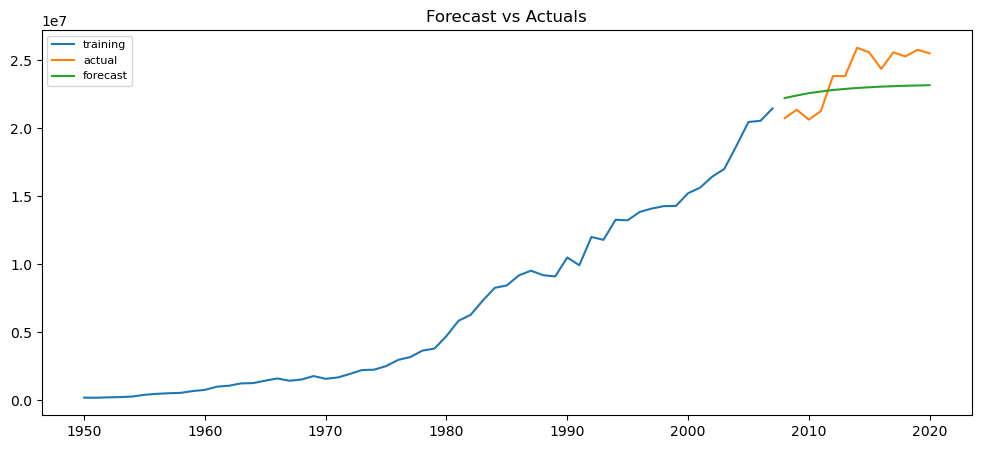

In [127]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_arima, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

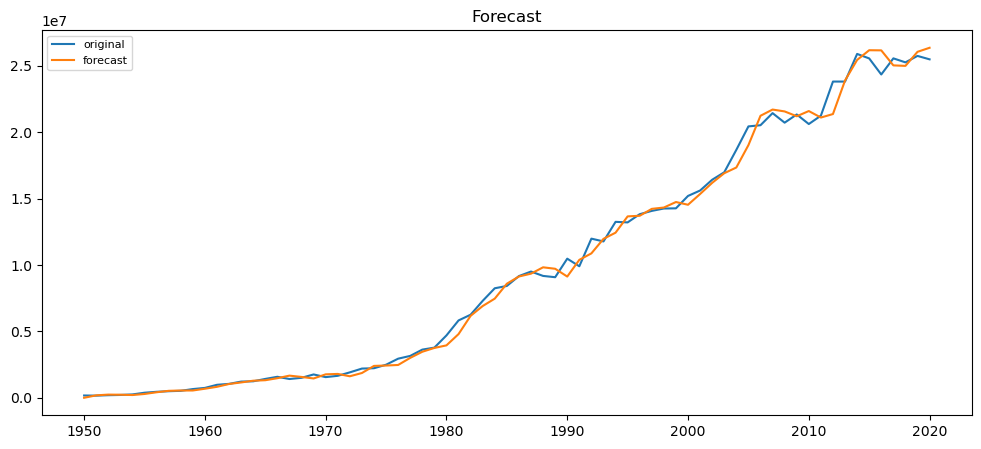

In [128]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(final_arima.fittedvalues, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### creating dataframe for future forecasting

In [129]:
#date = pd.Timestamp(dataset.index[-1])
future_dates=[df.index[-1] + DateOffset(years=x) for x in range(0,6)]
future_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_df.tail()

,CO2 emission per year
2021-01-01,NaN
2022-01-01,NaN
2023-01-01,NaN
2024-01-01,NaN
2025-01-01,NaN


In [130]:
df.tail()

,CO2 emission per year
Year,
2016-01-01,24345622.0
2017-01-01,25561278.0
2018-01-01,25259630.0
2019-01-01,25744983.0
2020-01-01,25487430.0


In [131]:
len(future_df)

5

### Forecasting for next 5 years using Final ARIMA model

In [132]:
future_df["CO2 emission per year"] = final_arima.predict(start = 71, end = 76, dynamic= True) 

In [133]:
future_df

,CO2 emission per year
2021-01-01,2.563101e+07
2022-01-01,2.577108e+07
2023-01-01,2.606332e+07
2024-01-01,2.644478e+07
2025-01-01,2.668281e+07


In [134]:
df.tail()

,CO2 emission per year
Year,
2016-01-01,24345622.0
2017-01-01,25561278.0
2018-01-01,25259630.0
2019-01-01,25744983.0
2020-01-01,25487430.0


In [135]:
future_df.tail()

,CO2 emission per year
2021-01-01,2.563101e+07
2022-01-01,2.577108e+07
2023-01-01,2.606332e+07
2024-01-01,2.644478e+07
2025-01-01,2.668281e+07


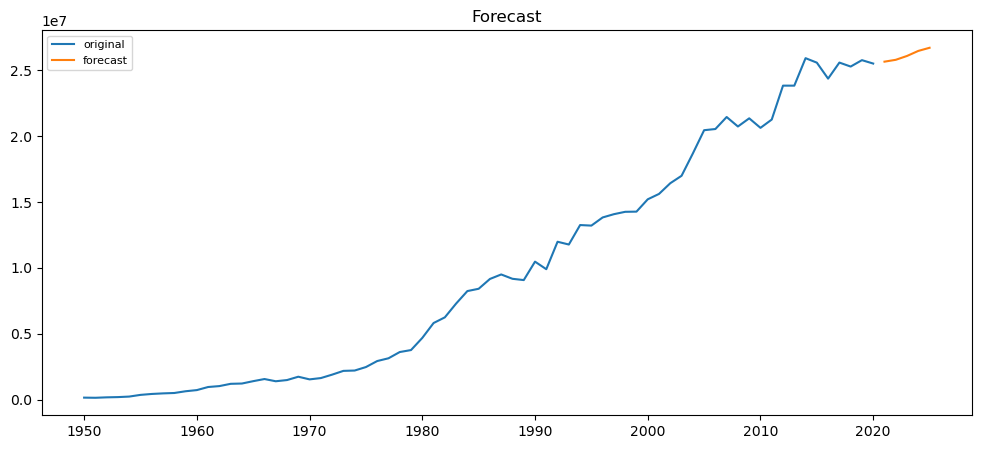

In [136]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df["CO2 emission per year"], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Forecast for 10 years

In [137]:
future_dates_10=[df.index[-1]+ DateOffset(years=x)for x in range(0,11)]
future_df_10=pd.DataFrame(index=future_dates_10[1:],columns=df.columns)
future_df_10


,CO2 emission per year
2021-01-01,NaN
2022-01-01,NaN
2023-01-01,NaN
2024-01-01,NaN
2025-01-01,NaN
2026-01-01,NaN
2027-01-01,NaN
2028-01-01,NaN
2029-01-01,NaN
2030-01-01,NaN


In [138]:
future_df_10['CO2 emission per year'] = final_arima.predict(start = 71, end = 81, dynamic= True) 

In [139]:
future_df_10

,CO2 emission per year
2021-01-01,2.563101e+07
2022-01-01,2.577108e+07
2023-01-01,2.606332e+07
2024-01-01,2.644478e+07
2025-01-01,2.668281e+07
2026-01-01,2.701835e+07
2027-01-01,2.730073e+07
2028-01-01,2.759274e+07
2029-01-01,2.788500e+07
2030-01-01,2.816568e+07


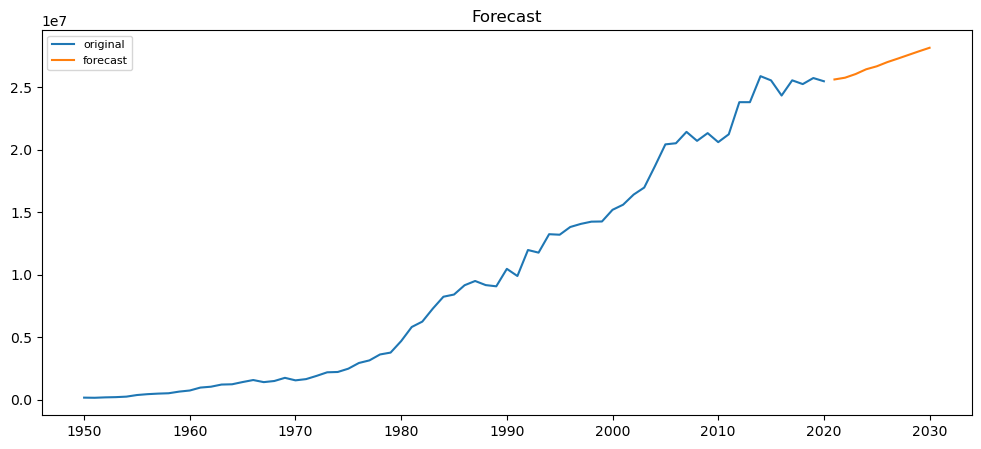

In [140]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df_10['CO2 emission per year'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [141]:
# Exporting to csv file
future_df_10.to_csv(r'forecast_data_10years.csv',index=True)

In [142]:
pickle.dump(final_arima, open('Forecast_arima.pkl','wb'))